In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [3]:
df=pd.read_csv('Housing.csv')
df.head()

,price,area,bedrooms,bathrooms,stories,mainroad,guestroom,basement,hotwaterheating,airconditioning,parking,prefarea,furnishingstatus
0,13300000,7420,4,2,3,yes,no,no,no,yes,2,yes,furnished
1,12250000,8960,4,4,4,yes,no,no,no,yes,3,no,furnished
2,12250000,9960,3,2,2,yes,no,yes,no,no,2,yes,semi-furnished
3,12215000,7500,4,2,2,yes,no,yes,no,yes,3,yes,furnished
4,11410000,7420,4,1,2,yes,yes,yes,no,yes,2,no,furnished


# EDA

In [4]:
df.isnull().sum()

price               0
area                0
bedrooms            0
bathrooms           0
stories             0
mainroad            0
guestroom           0
basement            0
hotwaterheating     0
airconditioning     0
parking             0
prefarea            0
furnishingstatus    0
dtype: int64

In [5]:
df.shape

(545, 13)

In [6]:
df.head()

,price,area,bedrooms,bathrooms,stories,mainroad,guestroom,basement,hotwaterheating,airconditioning,parking,prefarea,furnishingstatus
0,13300000,7420,4,2,3,yes,no,no,no,yes,2,yes,furnished
1,12250000,8960,4,4,4,yes,no,no,no,yes,3,no,furnished
2,12250000,9960,3,2,2,yes,no,yes,no,no,2,yes,semi-furnished
3,12215000,7500,4,2,2,yes,no,yes,no,yes,3,yes,furnished
4,11410000,7420,4,1,2,yes,yes,yes,no,yes,2,no,furnished


In [7]:
df.columns

Index(['price', 'area', 'bedrooms', 'bathrooms', 'stories', 'mainroad',
       'guestroom', 'basement', 'hotwaterheating', 'airconditioning',
       'parking', 'prefarea', 'furnishingstatus'],
      dtype='object')

In [8]:
df['furnishingstatus'].value_counts()

furnishingstatus
semi-furnished    227
unfurnished       178
furnished         140
Name: count, dtype: int64

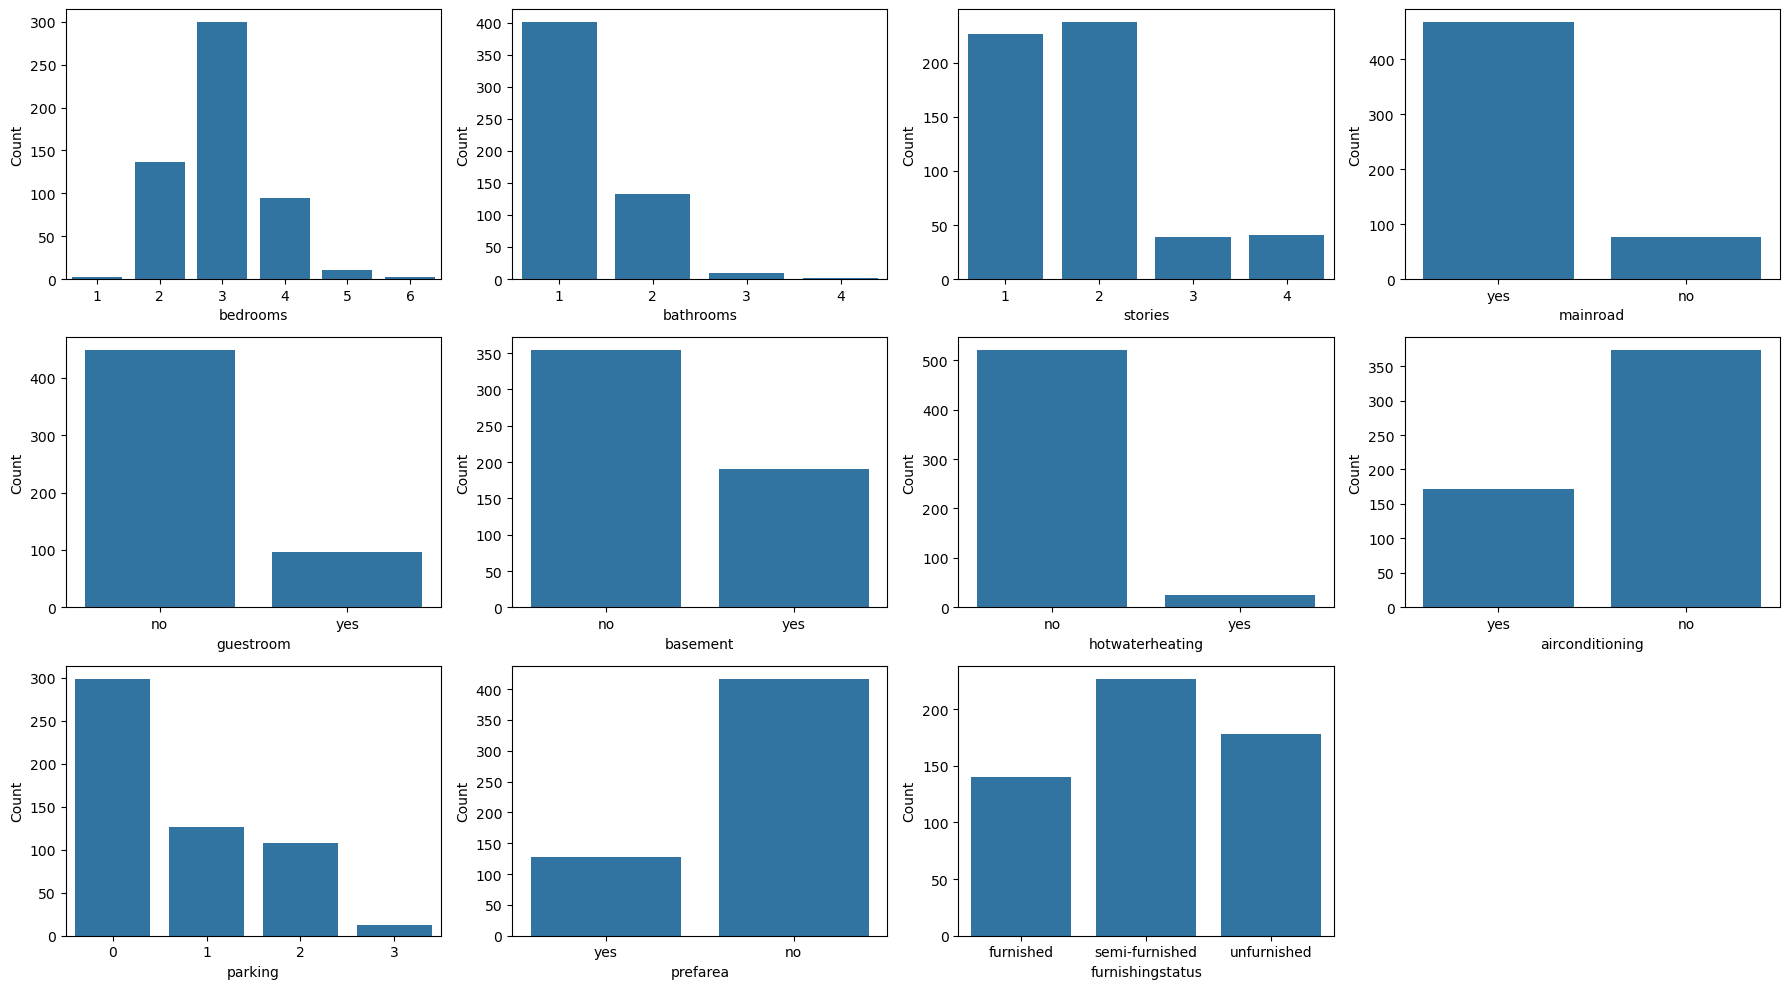

In [9]:
cols=['bedrooms', 'bathrooms', 'stories', 'mainroad',
       'guestroom', 'basement', 'hotwaterheating', 'airconditioning',
       'parking', 'prefarea', 'furnishingstatus']
plt.figure(figsize=(18,10))
plotnumber=1
for i in cols:
    plt.subplot(3,4,plotnumber)
    plotnumber+=1
    sns.countplot(data=df,x=i)
    plt.xlabel(i)
    plt.ylabel('Count')
plt.tight_layout()
plt.show()

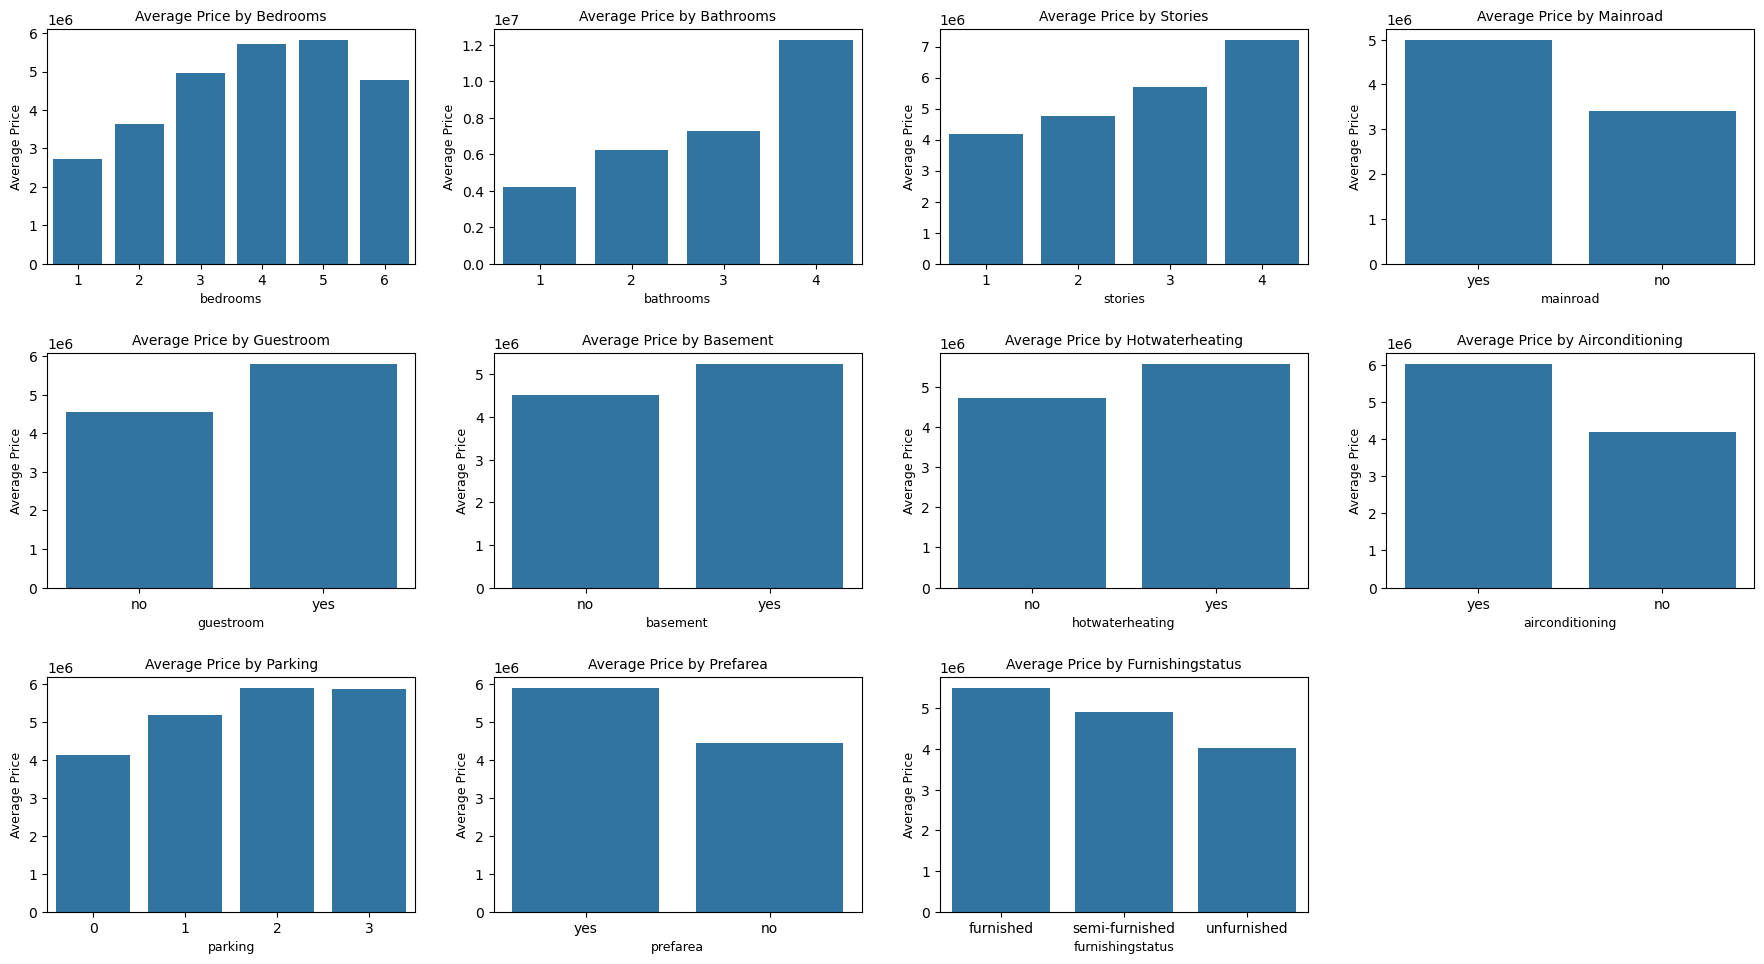

In [10]:
#how each feature affect the price
plt.figure(figsize=(18, 10))
plotnumber = 1
for i in cols:
    plt.subplot(3, 4, plotnumber)
    plotnumber += 1
    sns.barplot(data=df, x=i, y='price', estimator='mean',errorbar=None)
    plt.xlabel(i, fontsize=9)
    plt.ylabel('Average Price', fontsize=9)
    plt.title(f'Average Price by {i.capitalize()}', fontsize=10)
plt.tight_layout(pad=2.0)
plt.show()

In [11]:
df.isnull().sum()

price               0
area                0
bedrooms            0
bathrooms           0
stories             0
mainroad            0
guestroom           0
basement            0
hotwaterheating     0
airconditioning     0
parking             0
prefarea            0
furnishingstatus    0
dtype: int64

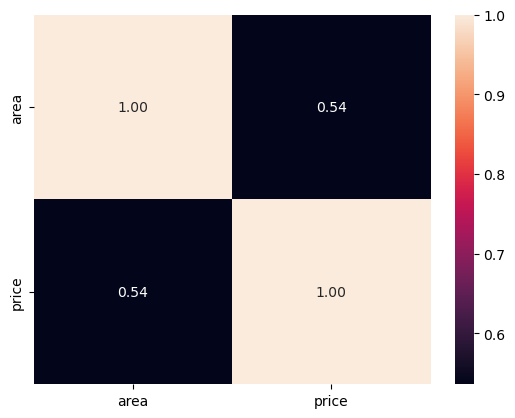

In [12]:
num=df[['area','price']]
cor=num.corr()
sns.heatmap(cor,annot=True,fmt='.2f')
plt.show()

# Model fitting

In [13]:
from sklearn.model_selection import train_test_split
X = df.drop('price', axis=1)
y = df['price']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


In [14]:
#outliers
def outliers_boxplot(features,target):
    plt.figure(figsize=(10,8))
    plt.subplot(1,2,1)
    sns.boxplot(y=features)
    plt.subplot(1,2,2)
    sns.boxplot(y=target)
    plt.show()

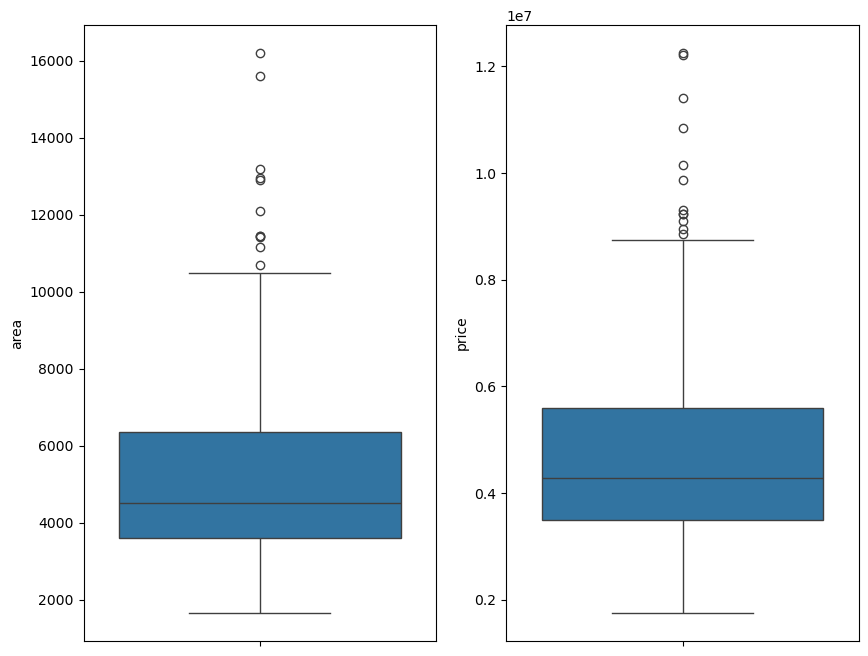

In [15]:
#train
outliers_boxplot(X_train['area'],y_train)

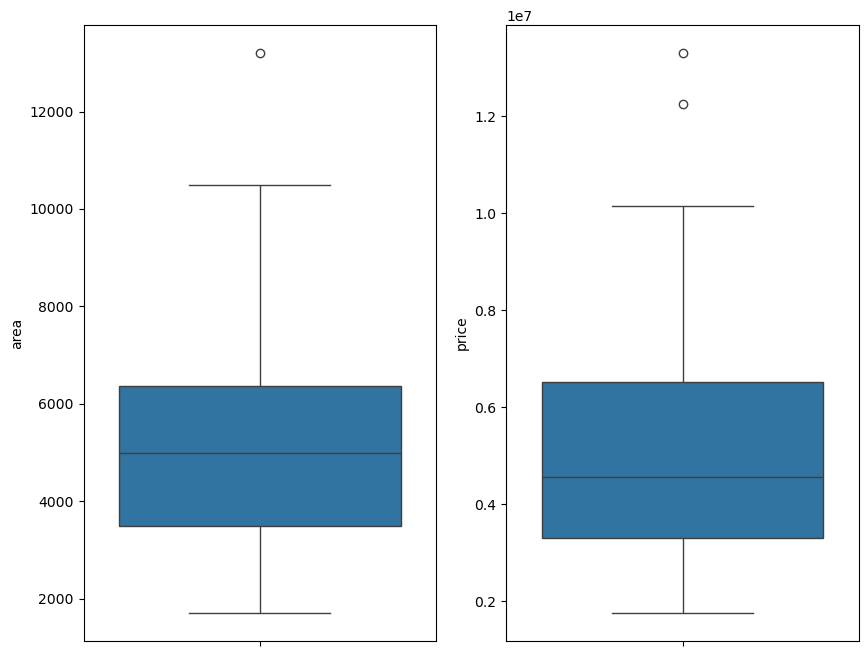

In [16]:
#test
outliers_boxplot(X_test['area'],y_test)

In [17]:
y_train = pd.DataFrame(y_train, columns=['price'])
y_test = pd.DataFrame(y_test, columns=['price'])


In [18]:
def distribution_plots(features,target):
    plt.figure(figsize=(15,10))
    plt.subplot(1,2,1)
    sns.kdeplot(data=features, x='area', fill=True, color='skyblue')
    plt.title(f'Distribution of area')
    plt.subplot(1,2,2)
    sns.kdeplot(data=target, x=target.columns[0], fill=True, color='salmon')
    plt.title(f'Distribution of price')
    plt.tight_layout()
    plt.show()

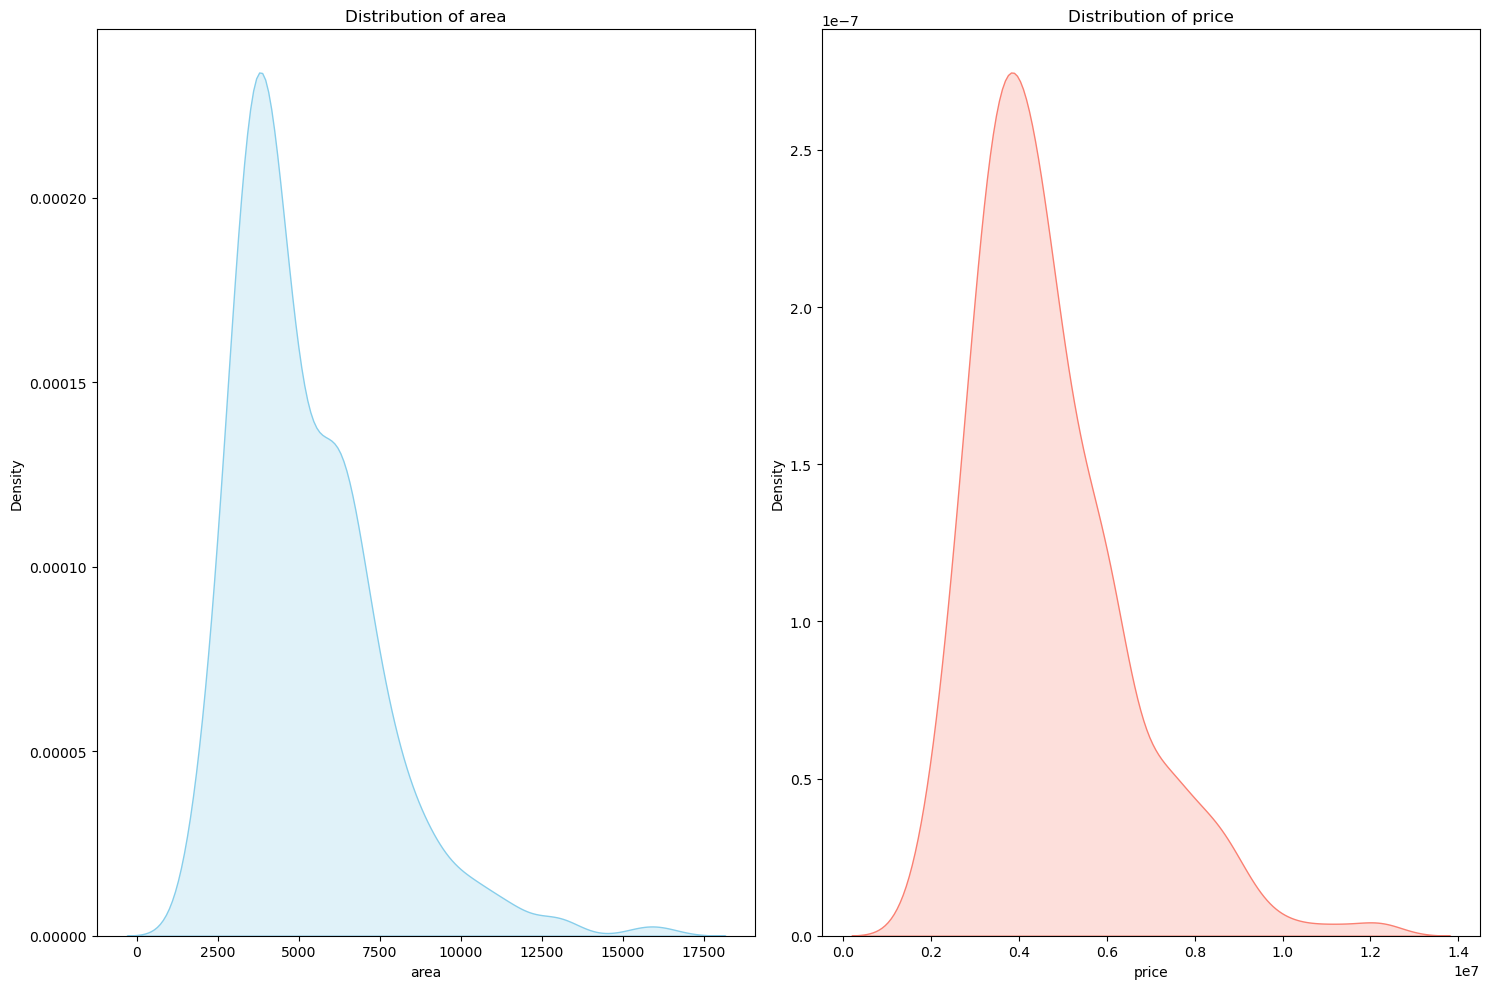

In [19]:
#Train data
distribution_plots(X_train,y_train)

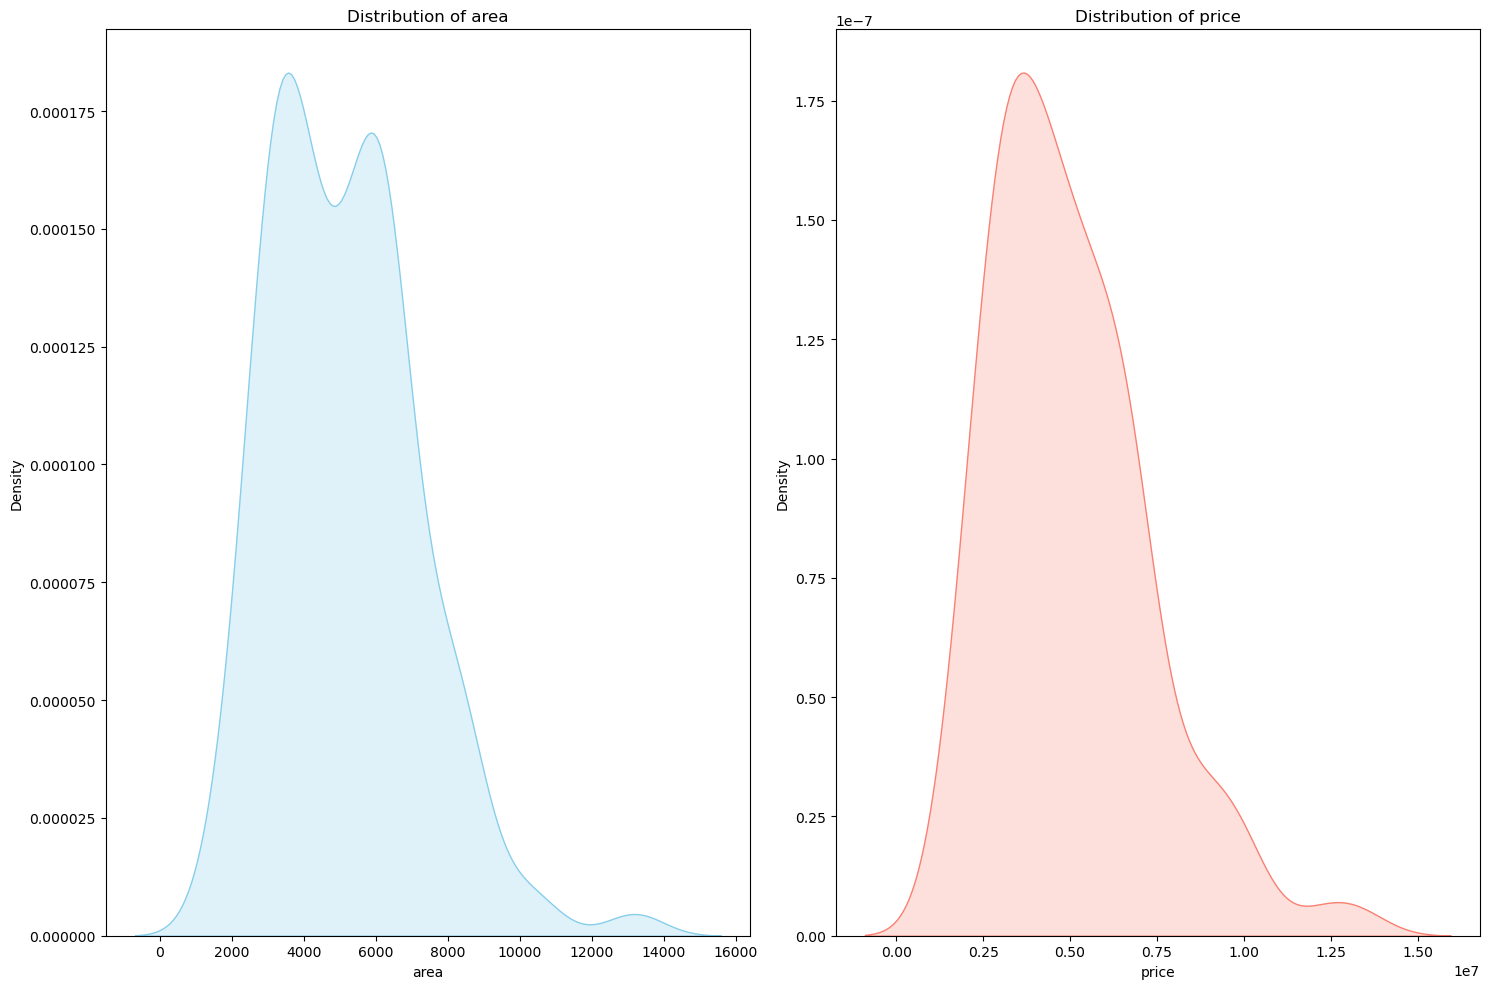

In [20]:
#Test data
distribution_plots(X_test,y_test)

In [21]:
print(X_train['area'].skew())
print(X_test['area'].skew())

1.4100560801498712
0.8651154492935523


In [22]:
X_train['area']=np.log1p(X_train['area'])
X_test['area']=np.log1p(X_test['area'])
y_train=np.log1p(y_train)
y_test=np.log1p(y_test)

In [23]:
num_cols = ['area']
bin_cols = ['mainroad','guestroom','basement','hotwaterheating','airconditioning','prefarea']
cat_cols = ['furnishingstatus']

In [24]:
from sklearn.preprocessing import OneHotEncoder
encoder = OneHotEncoder(drop='first', sparse_output=False)  # avoid dummy variable trap
X_train_cat = pd.DataFrame(
    encoder.fit_transform(X_train[cat_cols]),
    index=X_train.index,
    columns=encoder.get_feature_names_out(cat_cols)  # assigns meaningful names
)
# Transform TEST
X_test_cat = pd.DataFrame(
    encoder.transform(X_test[cat_cols]),
    index=X_test.index,
    columns=encoder.get_feature_names_out(cat_cols)
)
# Drop original categorical column and join encoded columns
X_train = X_train.drop(cat_cols, axis=1).join(X_train_cat)
X_test = X_test.drop(cat_cols, axis=1).join(X_test_cat)


In [25]:
for col in bin_cols:
    X_train[col] = X_train[col].map({'yes':1, 'no':0})
    X_test[col] = X_test[col].map({'yes':1, 'no':0})

In [26]:
X_train

,area,bedrooms,bathrooms,stories,mainroad,guestroom,basement,hotwaterheating,airconditioning,parking,prefarea,furnishingstatus_semi-furnished,furnishingstatus_unfurnished
46,8.699681,3,2,4,1,0,0,0,1,1,0,0.0,0.0
93,8.881975,3,2,1,1,0,1,0,1,3,0,1.0,0.0
335,8.247220,2,1,1,1,0,1,0,1,2,0,0.0,0.0
412,7.867489,3,1,2,1,0,1,0,0,0,1,0.0,1.0
471,8.229778,3,1,2,1,0,0,0,0,0,0,0.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
71,8.699681,4,2,4,1,0,0,0,1,0,0,0.0,1.0
106,8.603554,4,2,1,1,0,1,0,1,0,1,1.0,0.0
270,8.412055,3,2,3,1,0,0,1,0,1,0,0.0,0.0
435,8.304247,2,1,1,1,0,0,0,0,0,0,0.0,1.0


In [27]:
y_train=y_train.squeeze()
y_test=y_test.squeeze()

In [28]:
X_train.head()
#y_train

,area,bedrooms,bathrooms,stories,mainroad,guestroom,basement,hotwaterheating,airconditioning,parking,prefarea,furnishingstatus_semi-furnished,furnishingstatus_unfurnished
46,8.699681,3,2,4,1,0,0,0,1,1,0,0.0,0.0
93,8.881975,3,2,1,1,0,1,0,1,3,0,1.0,0.0
335,8.247220,2,1,1,1,0,1,0,1,2,0,0.0,0.0
412,7.867489,3,1,2,1,0,1,0,0,0,1,0.0,1.0
471,8.229778,3,1,2,1,0,0,0,0,0,0,0.0,1.0


In [29]:
from sklearn.linear_model import LinearRegression
linear=LinearRegression()
linear.fit(X_train,y_train)

,fit_intercept,True
,copy_X,True
,tol,1e-06
,n_jobs,None
,positive,False


In [30]:
y_test_pred=linear.predict(X_test)

In [31]:
y_train_pred=linear.predict(X_train)

In [32]:
from sklearn.metrics import r2_score,mean_absolute_error
r2_train = r2_score(y_train, y_train_pred)
r2_test = r2_score(y_test, y_test_pred)
n_train = X_train.shape[0]  # number of training samples
p = X_train.shape[1]        # number of features
residuals_train=y_train-y_train_pred
residuals_test=y_test-y_test_pred
n_test = X_test.shape[0]    # number of test samples

In [33]:
adjusted_r2_train = 1 - (1 - r2_train) * (n_train - 1) / (n_train - p - 1)
adjusted_r2_test = 1 - (1 - r2_test) * (n_test - 1) / (n_test - p - 1)
print(f"Train R²: {r2_train:.4f}, Adjusted R²: {adjusted_r2_train:.4f}")
print(f"Test R²: {r2_test:.4f}, Adjusted R²: {adjusted_r2_test:.4f}")#Drop is not too high so not overfited
print(f"Train MAE: {mean_absolute_error(y_train,y_train_pred):.4f}")
print(f"Test MAE: {mean_absolute_error(y_test,y_test_pred):.4f}")

Train R²: 0.7154, Adjusted R²: 0.7066
Test R²: 0.6782, Adjusted R²: 0.6342
Train MAE: 0.1448
Test MAE: 0.1998


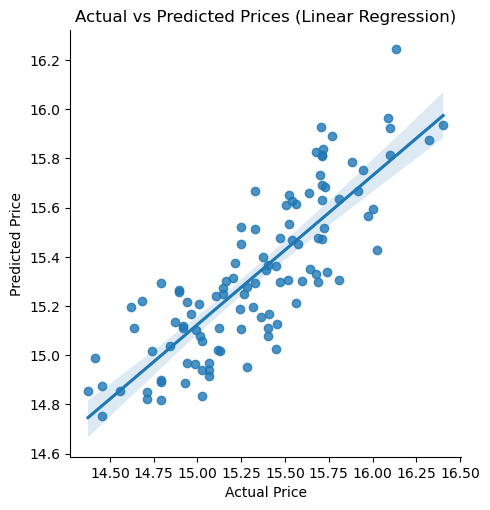

In [34]:
df_plot = pd.DataFrame({'Actual': y_test, 'Predicted': y_test_pred})
sns.lmplot(x='Actual', y='Predicted', data=df_plot, height=5)
plt.title('Actual vs Predicted Prices (Linear Regression)')
plt.xlabel('Actual Price')
plt.ylabel('Predicted Price')
plt.show()


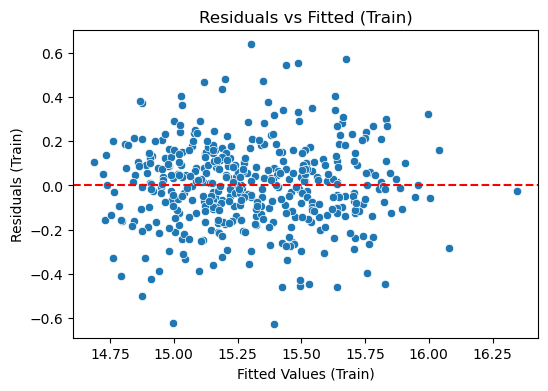

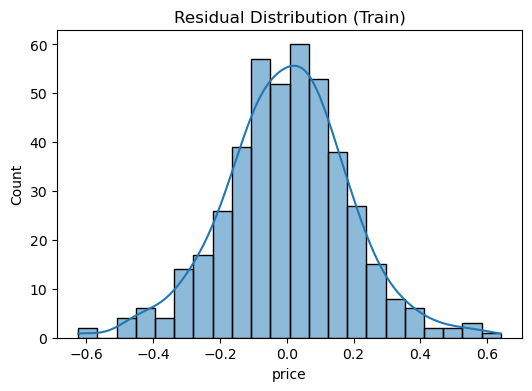

In [35]:
#Residual Analysis
plt.figure(figsize=(6,4))
sns.scatterplot(x=y_train_pred, y=residuals_train)
plt.axhline(0, color='red', linestyle='--')
plt.xlabel("Fitted Values (Train)")
plt.ylabel("Residuals (Train)")
plt.title("Residuals vs Fitted (Train)")
plt.show()
plt.figure(figsize=(6,4))
sns.histplot(residuals_train, kde=True)
plt.title("Residual Distribution (Train)")
plt.show()

In [ ]:
#VIF
from statsmodels.stats.outliers_influence import variance_inflation_factor
from statsmodels.tools.tools import add_constant
from statsmodels.stats.diagnostic import het_breuschpagan
from statsmodels.stats.stattools import durbin_watson
from scipy import stats
X_train_const = add_constant(X_train)
vif_data = pd.DataFrame()
vif_data["feature"] = X_train_const.columns
vif_data["VIF"] = [variance_inflation_factor(X_train_const.values, i) for i in range(X_train_const.shape[1])]
print("\nVIF Data:\n", vif_data)
#no multicollinearity 


VIF Data:
                             feature         VIF
0                             const  585.221703
1                              area    1.390314
2                          bedrooms    1.380334
3                         bathrooms    1.297626
4                           stories    1.515388
5                          mainroad    1.217924
6                         guestroom    1.286236
7                          basement    1.387679
8                   hotwaterheating    1.038493
9                   airconditioning    1.281200
10                          parking    1.220406
11                         prefarea    1.133881
12  furnishingstatus_semi-furnished    1.587945
13     furnishingstatus_unfurnished    1.696088


In [36]:
house = np.array([[8.699681,3,2,4,1,0,0,0,1,1,0,0.0,0.0]])
predicted_price1=linear.predict(house)
predicted_price=np.expm1(predicted_price1)
print("Predicted Price for the given house:", predicted_price[0])

Predicted Price for the given house: 7064337.099956758


c:\Users\Ashvitta\anaconda3\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(


In [37]:
import pickle 
with open('housing_price_model.pkl', 'wb') as file:
    pickle.dump(linear, file)
print("Model saved successfully as 'housing_price_model.pkl'")


Model saved successfully as 'housing_price_model.pkl'
